In [1]:
import jax
import jax.numpy as jnp
from scipy.linalg import block_diag
import numpy as np
from sklearn.datasets import load_breast_cancer, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns


# Figures and Colors
%config InlineBackend.figure_formats = ['svg']
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.title_fontsize'] = 10
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['figure.dpi'] = 250
matplotlib.rcParams['figure.figsize'] = (4,3)
cmap = plt.get_cmap("viridis")
colors = sns.color_palette("colorblind")
palette = sns.color_palette("Set2")
colors_b = sns.color_palette("Purples")
colors_g = sns.color_palette("Greens")
colors_r = sns.color_palette("Reds")
blues = plt.get_cmap("Blues")(np.linspace(0, 1, 9))

# Attribute dictionary
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

### Landscape definition

In [2]:
def get_random_rot(dr):
    # one way to generate a random rotation (Wigner's theorem)
    A = np.random.normal(size=(dr,int(2*dr)))/int(2*dr)
    _,U = np.linalg.eigh(A@A.T)
    return U

def get_hessian_from_details(H_det):
    blocks = []
    for b in range(len(H_det)):
        db = len(H_det[b])
        U = get_random_rot(db)
        blocks.append(U.T@np.diag(np.array(H_det[b]))@U)
    return block_diag(*blocks)

# Details of the Hessian as in https://arxiv.org/pdf/2402.16788v2
H_details_het = [[1,2,3],[99,100,101],[4998,4999,5000]]
H_details_hom = [[1,99, 4998],[2, 100, 4999],[3,101,5000]]

# Sampling the Hessian!
H_het = get_hessian_from_details(H_details_het)
H_hom = get_hessian_from_details(H_details_hom)

#dimensions
d,n = H_het.shape  #would love n>>d but actually would be same under uniform sampling

# Sampling data that generates this Hessian
eig_het, U_het = np.linalg.eigh(H_het)
eig_hom, U_hom = np.linalg.eigh(H_hom)
X_het = np.sqrt(n) * U_het@np.sqrt(np.diag(eig_het))#@U_het.T
X_hom = np.sqrt(n) * U_hom@np.sqrt(np.diag(eig_hom))#@U_hom.T

## Test everything is ok

Recall that for the problem $\frac{1}{n}\sum_{i=1}^n (x_i^\top w)^2$ the Hessian is $\frac{1}{n}XX^\top$

Note: where the solution is does not affect Hessian, so we put it $w^* = 0$.

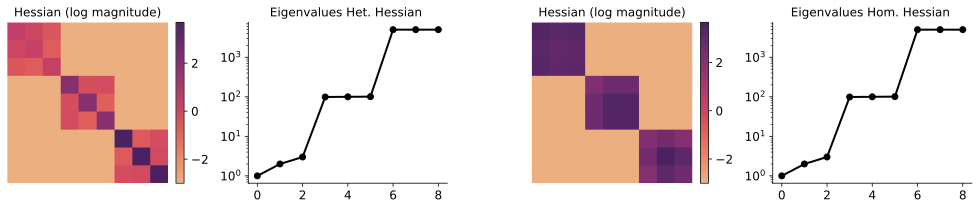

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))  # 1 row, 4 columns

H1 = (X_het@X_het.T) / n
e1,_ = np.linalg.eigh(H1)
im1 = axs[0].imshow(np.log10(np.abs(H1)+1e-3), cmap='Blues')
axs[0].set_title('Hessian (log magnitude)')
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

axs[1].plot(e1,'-o')
axs[1].set_title('Eigenvalues Het. Hessian ')
axs[1].set_yscale('log')

H2 = (X_hom@X_hom.T) / n
e2,_ = np.linalg.eigh(H2)
im2 = axs[2].imshow(np.log10(np.abs(H2)+1e-3), cmap='Blues')
axs[2].set_title('Hessian (log magnitude)')
axs[2].axis('off')
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

axs[3].plot(e2,'-o')
axs[3].set_yscale('log')
axs[3].set_title('Eigenvalues Hom. Hessian ')

plt.tight_layout()
plt.savefig('hessians.png', format="png", bbox_inches="tight")


### Training loop

In [41]:
def loss(XX,ww): return (0.5/XX.shape[1])*np.linalg.norm(XX.T@ww)**2
def grad(XX,ww): return (1/XX.shape[1])*XX@XX.T@ww

def get_wa_cosine(total_iters):
    warmup_iters = int(0.05 * total_iters)
    decay_iters = total_iters - warmup_iters
    warmup = jnp.linspace(0, 1, warmup_iters)
    decay = 0.5 * (1 + jnp.cos(jnp.pi * jnp.arange(decay_iters) / decay_iters))
    return jnp.concatenate([warmup, decay])

def train(XX, opt, lrs, bs, mollifier=0):
    total_iters = 500
    b1=0.95
    cosine = get_wa_cosine(total_iters)
    losses = []
    upper_var = []
    lower_var = []
    Ds = []
    Ds_upper_var = []
    Ds_lower_var = []
    for i in range(len(lrs)):
        l_loc=[]
        D_loc=[]
        for _ in range(10): #3 seeds
            w = 1+0*np.random.normal(size=(d,))/np.sqrt(d)
            l_ex = []
            D_ex = []
            for k in range(total_iters):
                if k==0: #init momentum parameters
                    m = np.zeros((d,))
                    D = np.zeros((d,))
                D_ex.append(D)
                l_ex.append(loss(XX,w))
                b = np.random.choice(n, size=bs, replace=False)
                g = grad(XX[:,b],w)
                if opt=='adam':
                    D = b1*D+(1-b1)*b1*((g-m)**2)
                    m = b1*m+(1-b1)*g
                    update = -lrs[i]*cosine[k]*m/(np.sqrt(m**2 + D)+1e-8)
                if (opt=='sgd') or (opt=='sgd-clip'):
                    m = b1*m+(1-b1)*g
                    update = -lrs[i]*cosine[k]*m
                if (opt=='sign'):
                    m = b1*m+(1-b1)*g
                    update = -lrs[i]*cosine[k]*m/(np.sqrt(m**2)+mollifier)#*np.sign(m)
                w = w + update
            l_loc.append(l_ex)
            D_loc.append(D_ex)
        l_array = np.array(l_loc)
        D_array = np.array(D_loc)
        
        ## loss processing
        filtered = l_array[np.nanmax(l_array, axis=1) < 1e8]
        losses.append(np.nanquantile(filtered, q=0.5, axis=0))
        upper_var.append(np.nanquantile(filtered, q=0.75, axis=0))
        lower_var.append(np.nanquantile(filtered, q=0.25, axis=0))
        
        ### Ds processing
        Ds.append(np.mean(D_array,axis=0))
        Ds_upper_var.append(np.nanquantile(D_array, q=0.75, axis=0))
        Ds_lower_var.append(np.nanquantile(D_array, q=0.25, axis=0))
    return losses, upper_var, lower_var, Ds, Ds_upper_var, Ds_lower_var

### Running and Plotting

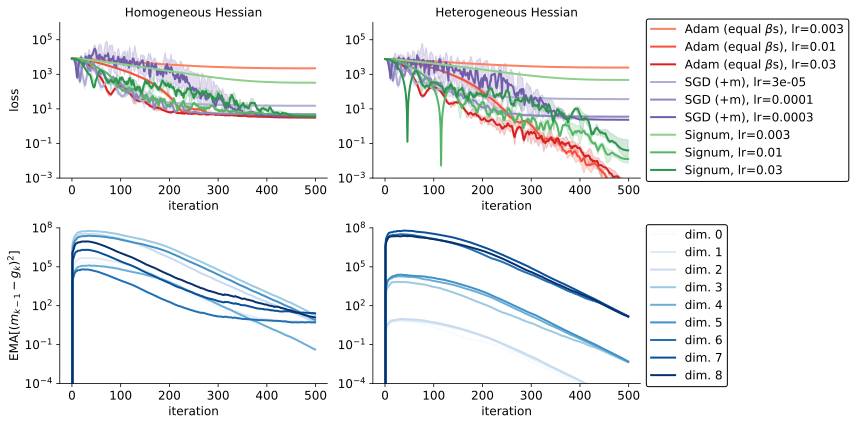

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12,6))
def produce_panel(idx_i,setup,lrs_sgd,lrs_adam,lrs_sign,bb):
    if setup=='Homogeneous':
        XXX = X_hom
    elif setup =='Heterogeneous':
        XXX = X_het
    losses_sgd, upper_sgd, lower_sgd, _, _, _ = train(XXX, 'sgd', lrs_sgd, bb)
    losses_adam, upper_adam, lower_adam, Ds, _, _ = train(XXX, 'adam', lrs_adam, bb)
    losses_sign, upper_sign, lower_sign, _, _, _ = train(XXX, 'sign', lrs_sign, bb)
    
    # Adam
    for i in range(len(lrs_adam)):
        axs[0,idx_i].plot(losses_adam[i], label=r'Adam (equal $\beta$s), lr='+str(lrs_adam[i]), color = colors_r[2+i])
        axs[0,idx_i].fill_between(np.arange(len(losses_adam[i])),lower_adam[i],upper_adam[i],color=colors_r[2+i],alpha=0.2)
    for j in range(d):
        axs[1,idx_i].plot(np.array(Ds)[1,:,j], color = blues[j], label='dim. '+str(j))
    axs[1,idx_i].set_yscale('log')
    axs[1,idx_i].set_xlabel('iteration')
    axs[1,idx_i].set_ylim([1e-4,1e8])
    if idx_i==0:
        axs[1,idx_i].set_ylabel(r'EMA[$(m_{k-1}-g_k)^2$]')
    else:
        axs[1,idx_i].legend(framealpha=1, facecolor='white', edgecolor='black',loc='center left', bbox_to_anchor=(1, 0.5))
    
    # SGD and signum
    for i in range(len(lrs_sgd)):
        axs[0,idx_i].plot(losses_sgd[i], label='SGD (+m), lr='+str(lrs_sgd[i]), color = colors_b[2+i])
        axs[0,idx_i].fill_between(np.arange(len(losses_sgd[i])),lower_sgd[i],upper_sgd[i],color=colors_b[2+i],alpha=0.2)
    for i in range(len(lrs_sign)):
        axs[0,idx_i].plot(losses_sign[i], label='Signum, lr='+str(lrs_sign[i]), color = colors_g[2+i])
        axs[0,idx_i].fill_between(np.arange(len(losses_sign[i])),lower_sign[i],upper_sign[i],color=colors_g[2+i],alpha=0.2)
    axs[0,idx_i].set_yscale('log')
    axs[0,idx_i].set_xlabel('iteration')
    axs[0,idx_i].set_ylim([1e-3,1e6])
    axs[0,idx_i].set_title(setup+' Hessian')
    if idx_i==0:
        axs[0,idx_i].set_ylabel('loss')
    else:
        axs[0,idx_i].legend(framealpha=1, facecolor='white', edgecolor='black',loc='center left', bbox_to_anchor=(1, 0.5))

lrs_sgd = [0.00003, 0.0001, 0.0003]
lrs_adam = [0.003, 0.01, 0.03]
lrs_sign = [0.003, 0.01, 0.03]
produce_panel(0,'Homogeneous',lrs_sgd,lrs_adam,lrs_sign,3)
produce_panel(1,'Heterogeneous',lrs_sgd,lrs_adam,lrs_sign,3)
plt.tight_layout()
plt.savefig('h.png', format="png", bbox_inches="tight")


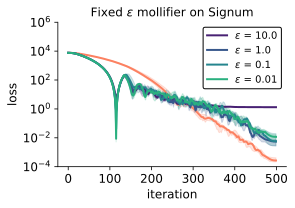

In [43]:
plt.figure(figsize=(4.2,3))
import matplotlib.cm as cm

colors_g = sns.color_palette('viridis',10)
def produce_panel_2(lrs_sgd,lrs_adam,lrs_sign,bb):
    moll = np.flip(np.array([1e-2, 1e-1, 1e0, 1e1]))
    XXX = X_het
    losses_adam, upper_adam, lower_adam, _, _, _ = train(XXX, 'adam', lrs_adam, bb)
    for i in range(len(lrs_adam)):
        plt.plot(losses_adam[i],  color = colors_r[2+i])
        plt.fill_between(np.arange(len(losses_adam[i])),lower_adam[i],upper_adam[i],color=colors_r[2+i],alpha=0.2)
    for j in range(len(moll)):
        losses_sign, upper_sign, lower_sign, _, _, _ = train(XXX, 'sign', lrs_sign, bb, mollifier = moll[j])    
        for i in range(len(lrs_sign)):
            plt.plot(losses_sign[i], label='$\epsilon$ = '+str(moll[j]), color = colors_g[int(2*j)])
            plt.fill_between(np.arange(len(losses_sign[i])),lower_sign[i],upper_sign[i],color=colors_g[int(2*j)],alpha=0.2)
    plt.yscale('log')
    plt.xlabel('iteration')
    plt.ylim([1e-4,1e6])
    plt.title('Fixed $\epsilon$ mollifier on Signum')
    plt.ylabel('loss')
    plt.legend(framealpha=1, facecolor='white', edgecolor='black',fontsize=10)

lrs_adam = [0.01]
lrs_sign = [0.01]
produce_panel_2(lrs_sgd,lrs_adam,lrs_sign,3)
plt.tight_layout()
plt.savefig('h.pdf', format="pdf", bbox_inches="tight")